In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")




## Importing and Exploring the Scraped Dataset:


In [18]:
books_df = pd.read_csv('books3_new.csv')

In [19]:
books_df.head()

,author,title,page_count,rating,ratingCount,firstPub_year,ogPub_year,Binding,language,followers,review_counts,Publisher,genres
0,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",374.0,4.32,7208164.0,2008.0,2008.0,Hardcover,English,"88,818",181983.0,ScholasticPress,Young Adult
1,J.K. Rowling,Harry Potter and the Order of the Phoenix (Har...,870.0,4.50,2861900.0,2003.0,2004.0,Paperback,English,"217,573",49921.0,ScholasticInc.,Fantasy
2,Harper Lee,To Kill a Mockingbird,336.0,4.27,5140956.0,1960.0,2006.0,Paperback,English,"12,234",100834.0,HarperPerennialModernClassics,Classics
3,Jane Austen,Pride and Prejudice,279.0,4.28,3495274.0,1813.0,2000.0,Paperback,English,"55,282",82868.0,ModernLibrary,Classics
4,Stephenie Meyer,"Twilight (The Twilight Saga, #1)",498.0,3.62,5608047.0,2005.0,2006.0,Paperback,English,"68,765",112802.0,"Little,BrownandCompany",Fantasy


In [20]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author         888 non-null    object 
 1   title          995 non-null    object 
 2   page_count     888 non-null    float64
 3   rating         888 non-null    float64
 4   ratingCount    888 non-null    float64
 5   firstPub_year  671 non-null    float64
 6   ogPub_year     669 non-null    float64
 7   Binding        671 non-null    object 
 8   language       667 non-null    object 
 9   followers      667 non-null    object 
 10  review_counts  667 non-null    float64
 11  Publisher      660 non-null    object 
 12  genres         667 non-null    object 
dtypes: float64(6), object(7)
memory usage: 101.7+ KB


## Data Cleaning and EDA:

In [21]:
# Check if there's any missing value
books_df.isnull().sum()

author           112
title              5
page_count       112
rating           112
ratingCount      112
firstPub_year    329
ogPub_year       331
Binding          329
language         333
followers        333
review_counts    333
Publisher        340
genres           333
dtype: int64

In [23]:
books_df.duplicated().any()

True

In [24]:
books_df[books_df.duplicated(keep=False)]

,author,title,page_count,rating,ratingCount,firstPub_year,ogPub_year,Binding,language,followers,review_counts,Publisher,genres
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Drop all the null values:
BooksClean_df = books_df.dropna(how='any', axis = 0)

In [26]:
BooksClean_df.isnull().sum()

author           0
title            0
page_count       0
rating           0
ratingCount      0
firstPub_year    0
ogPub_year       0
Binding          0
language         0
followers        0
review_counts    0
Publisher        0
genres           0
dtype: int64

In [27]:
BooksClean_df.duplicated().any()

False

In [28]:
BooksClean_df.shape

(660, 13)

In [29]:
#Remove commas from the followers column:
def removeComma(string_num):
    return int(string_num.replace(',' , ''))

BooksClean_df["followers"] = BooksClean_df["followers"].apply(removeComma)

/var/folders/p5/5cz9q1c15pn6hbl2m1csrmjh0000gn/T/ipykernel_95840/4231168553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BooksClean_df["followers"] = BooksClean_df["followers"].apply(removeComma)


In [30]:
BooksClean_df.head()

,author,title,page_count,rating,ratingCount,firstPub_year,ogPub_year,Binding,language,followers,review_counts,Publisher,genres
0,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",374.0,4.32,7208164.0,2008.0,2008.0,Hardcover,English,88818,181983.0,ScholasticPress,Young Adult
1,J.K. Rowling,Harry Potter and the Order of the Phoenix (Har...,870.0,4.50,2861900.0,2003.0,2004.0,Paperback,English,217573,49921.0,ScholasticInc.,Fantasy
2,Harper Lee,To Kill a Mockingbird,336.0,4.27,5140956.0,1960.0,2006.0,Paperback,English,12234,100834.0,HarperPerennialModernClassics,Classics
3,Jane Austen,Pride and Prejudice,279.0,4.28,3495274.0,1813.0,2000.0,Paperback,English,55282,82868.0,ModernLibrary,Classics
4,Stephenie Meyer,"Twilight (The Twilight Saga, #1)",498.0,3.62,5608047.0,2005.0,2006.0,Paperback,English,68765,112802.0,"Little,BrownandCompany",Fantasy


In [31]:
BooksClean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author         660 non-null    object 
 1   title          660 non-null    object 
 2   page_count     660 non-null    float64
 3   rating         660 non-null    float64
 4   ratingCount    660 non-null    float64
 5   firstPub_year  660 non-null    float64
 6   ogPub_year     660 non-null    float64
 7   Binding        660 non-null    object 
 8   language       660 non-null    object 
 9   followers      660 non-null    int64  
 10  review_counts  660 non-null    float64
 11  Publisher      660 non-null    object 
 12  genres         660 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 72.2+ KB


## Data Analysis and Visualization :

In [36]:
fig = px.histogram(BooksClean_df,
                  x = 'rating',
                  marginal = 'box',
                   nbins = 10,
                title = 'Distribution of ratings'
                   
                  )
fig.update_layout(bargap= 0.1)
fig.show()


In [66]:
fig = px.histogram(BooksClean_df,
                  x = 'genres',
                  marginal = 'box',
                   nbins = 10,
                color_discrete_sequence=['green'],
                title = 'Distribution of genres'
                   
                  )
fig.update_layout(bargap= 0.1)
fig.show()


In [38]:
fig = px.histogram(BooksClean_df,
                  x = 'ogPub_year',
                  marginal = 'box',
                   nbins = 10,
                title = 'Distribution of ratings'
                   
                  )
fig.update_layout(bargap= 0.1)
fig.show()


In [46]:
BooksClean_df = BooksClean_df.drop(BooksClean_df.loc[BooksClean_df['firstPub_year']< 0].index)

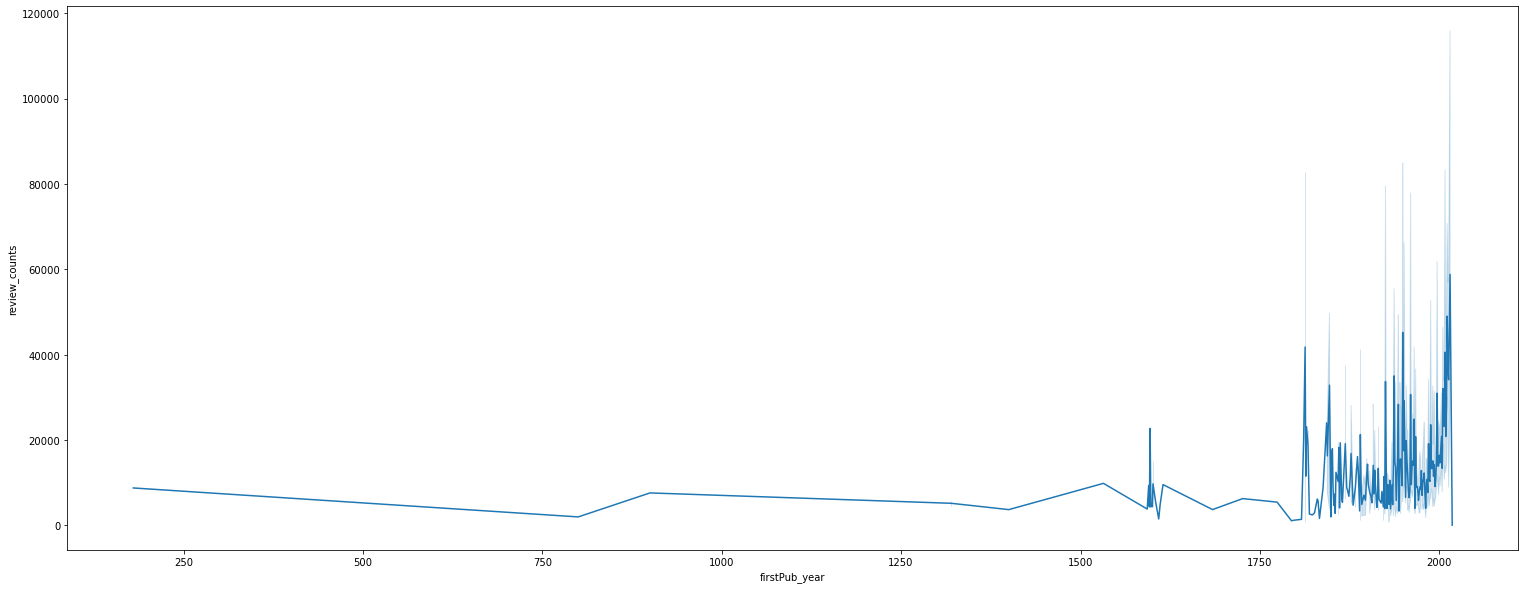

In [60]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
sns.lineplot(x="firstPub_year", y="review_counts", data=BooksClean_df);

## Compare the correlation for each feature with the target:

In [62]:
# Correlation:
print(BooksClean_df.rating.corr(BooksClean_df.page_count))#PageCount
print(BooksClean_df.rating.corr(BooksClean_df.ratingCount)) #RatingCount
print(BooksClean_df.rating.corr(BooksClean_df.followers))#followers
print(BooksClean_df.rating.corr(BooksClean_df.review_counts))#ReviewCount
print(BooksClean_df.rating.corr(BooksClean_df.firstPub_year))# FirstPublishedYear

0.25887187212582735
0.1241810745068998
0.16423694461051389
0.13553697425325234
0.16119855068273384


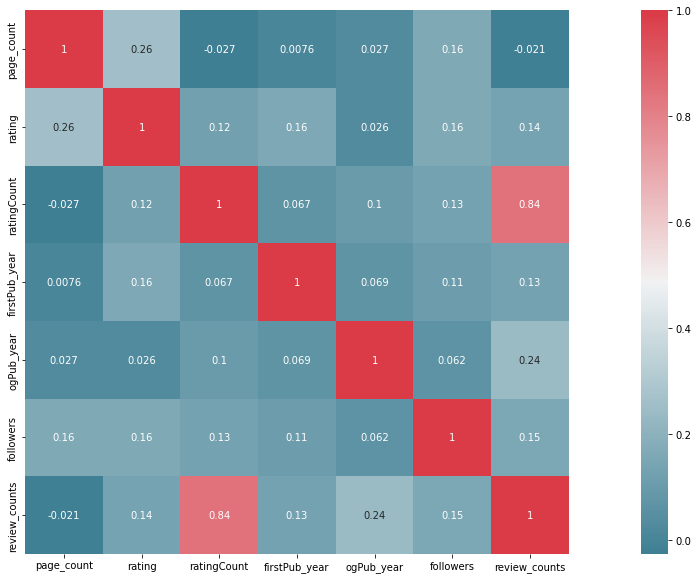

In [63]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
corr = BooksClean_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot = True);

- Pagecount,followers, review_Counts,ratingCount, firstPub_year has a good correlation with rating
- drop ogPub_year

### Bivariate Distribution:


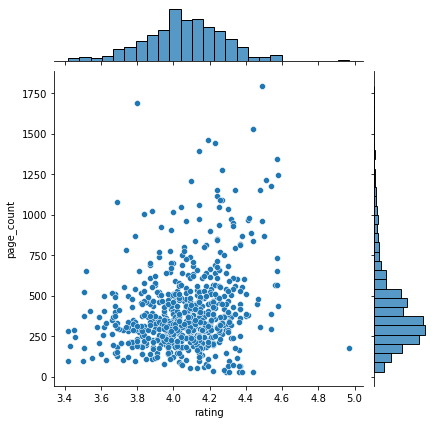

In [68]:
# Rating vs Pagecount
# fig = px.scatter(medical_df, 
#                  x='age', 
#                  y='charges', 
#                  color='smoker', 
#                  opacity=0.8, 
#                  hover_data=['sex'], 
#                  title='Age vs. Charges')
# fig.update_traces(marker_size=5)
# fig.show()
sns.jointplot(x = 'rating', y = 'page_count', data = BooksClean_df)

In [78]:
#Rating vs Pagecount
fig = px.scatter(BooksClean_df, 
                 x='rating', 
                 y='page_count', 
                 opacity=0.8,
                 hover_data = ['author', 'title','genres'],
                 title='Rating vs Number of Pages')
fig.update_traces(marker_size=5)
fig.show()

In [77]:
#Rating vs followers
fig = px.scatter(BooksClean_df, 
                 x='rating', 
                 y='followers', 
                 opacity=0.8,
                 hover_data = ['author', 'title','genres'],
                 title='Rating vs Followers')
fig.update_traces(marker_size=5)
fig.show()



In [80]:
BooksClean_df.columns

Index(['author', 'title', 'page_count', 'rating', 'ratingCount',
       'firstPub_year', 'ogPub_year', 'Binding', 'language', 'followers',
       'review_counts', 'Publisher', 'genres'],
      dtype='object')

### Let's start with a simple regression model as our base by using our numerical features only!

In [82]:
#the numeric predictors and target
X_num = BooksClean_df[['page_count','ratingCount','firstPub_year','followers',
       'review_counts',]]
y_num = BooksClean_df['rating']


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, test_size=0.2, random_state=42)

#simple linear regression model
lr = LinearRegression()
model_fit = lr.fit(X_train,y_train)

#getting predictions
y_pred = model_fit.predict(X_test)

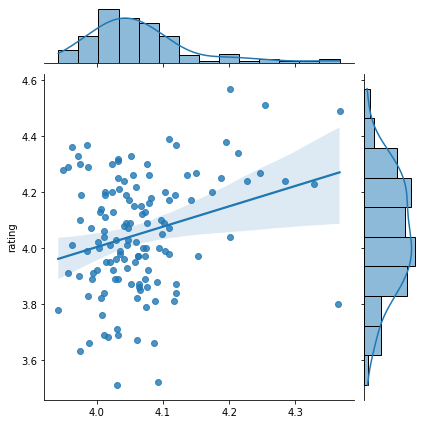

In [85]:
#ploting the actual vs predicted values 
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

In [87]:
print(f'Linear Regression R^2 score on train set: {model_fit.score(X_train, y_train):.4f}')
print(f'Linear Regression R^2 score on test set: {model_fit.score(X_test, y_test):.4f}')
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

Linear Regression R^2 score on train set: 0.1271
Linear Regression R^2 score on test set: 0.0602
Mean Absolute Error: 0.1605694205635357
Mean Squared Error: 0.04077581240914457
Root Mean Square Error (RMSE): 0.201930216681765


In [89]:
#compare the actual output values for X_test with the predicted values
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()})
pred.head(10)

,Actual,Predicted
0,4.10,3.973824
1,3.87,4.064079
2,3.93,4.045413
3,4.26,4.136516
4,4.07,4.108718
5,3.63,3.973993
6,4.07,4.046356
7,4.26,4.054254
8,4.20,4.102863
9,3.96,4.028681


### Not good enough, try adding categorical features:

In [92]:
# One hot encoding:

BooksClean_df = pd.get_dummies(BooksClean_df, columns=['genres'])

In [96]:
BooksClean_df.head()

,author,title,page_count,rating,ratingCount,firstPub_year,ogPub_year,Binding,language,followers,...,genres_Religion,genres_Romance,genres_Science,genres_Science Fiction,genres_Sequential Art,genres_Short Stories,genres_Thriller,genres_Travel,genres_Womens Fiction,genres_Young Adult
0,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",374.0,4.32,7208164.0,2008.0,2008.0,Hardcover,English,88818,...,0,0,0,0,0,0,0,0,0,1
1,J.K. Rowling,Harry Potter and the Order of the Phoenix (Har...,870.0,4.50,2861900.0,2003.0,2004.0,Paperback,English,217573,...,0,0,0,0,0,0,0,0,0,0
2,Harper Lee,To Kill a Mockingbird,336.0,4.27,5140956.0,1960.0,2006.0,Paperback,English,12234,...,0,0,0,0,0,0,0,0,0,0
3,Jane Austen,Pride and Prejudice,279.0,4.28,3495274.0,1813.0,2000.0,Paperback,English,55282,...,0,0,0,0,0,0,0,0,0,0
4,Stephenie Meyer,"Twilight (The Twilight Saga, #1)",498.0,3.62,5608047.0,2005.0,2006.0,Paperback,English,68765,...,0,0,0,0,0,0,0,0,0,0


In [97]:
BooksClean_df.columns

Index(['author', 'title', 'page_count', 'rating', 'ratingCount',
       'firstPub_year', 'ogPub_year', 'Binding', 'language', 'followers',
       'review_counts', 'Publisher', 'genres_Adventure',
       'genres_Autobiography', 'genres_Childrens', 'genres_Christian',
       'genres_Classics', 'genres_Crime', 'genres_Fantasy', 'genres_Fiction',
       'genres_Historical', 'genres_History', 'genres_Holiday',
       'genres_Horror', 'genres_Mystery', 'genres_Nonfiction',
       'genres_Philosophy', 'genres_Plays', 'genres_Poetry', 'genres_Religion',
       'genres_Romance', 'genres_Science', 'genres_Science Fiction',
       'genres_Sequential Art', 'genres_Short Stories', 'genres_Thriller',
       'genres_Travel', 'genres_Womens Fiction', 'genres_Young Adult'],
      dtype='object')

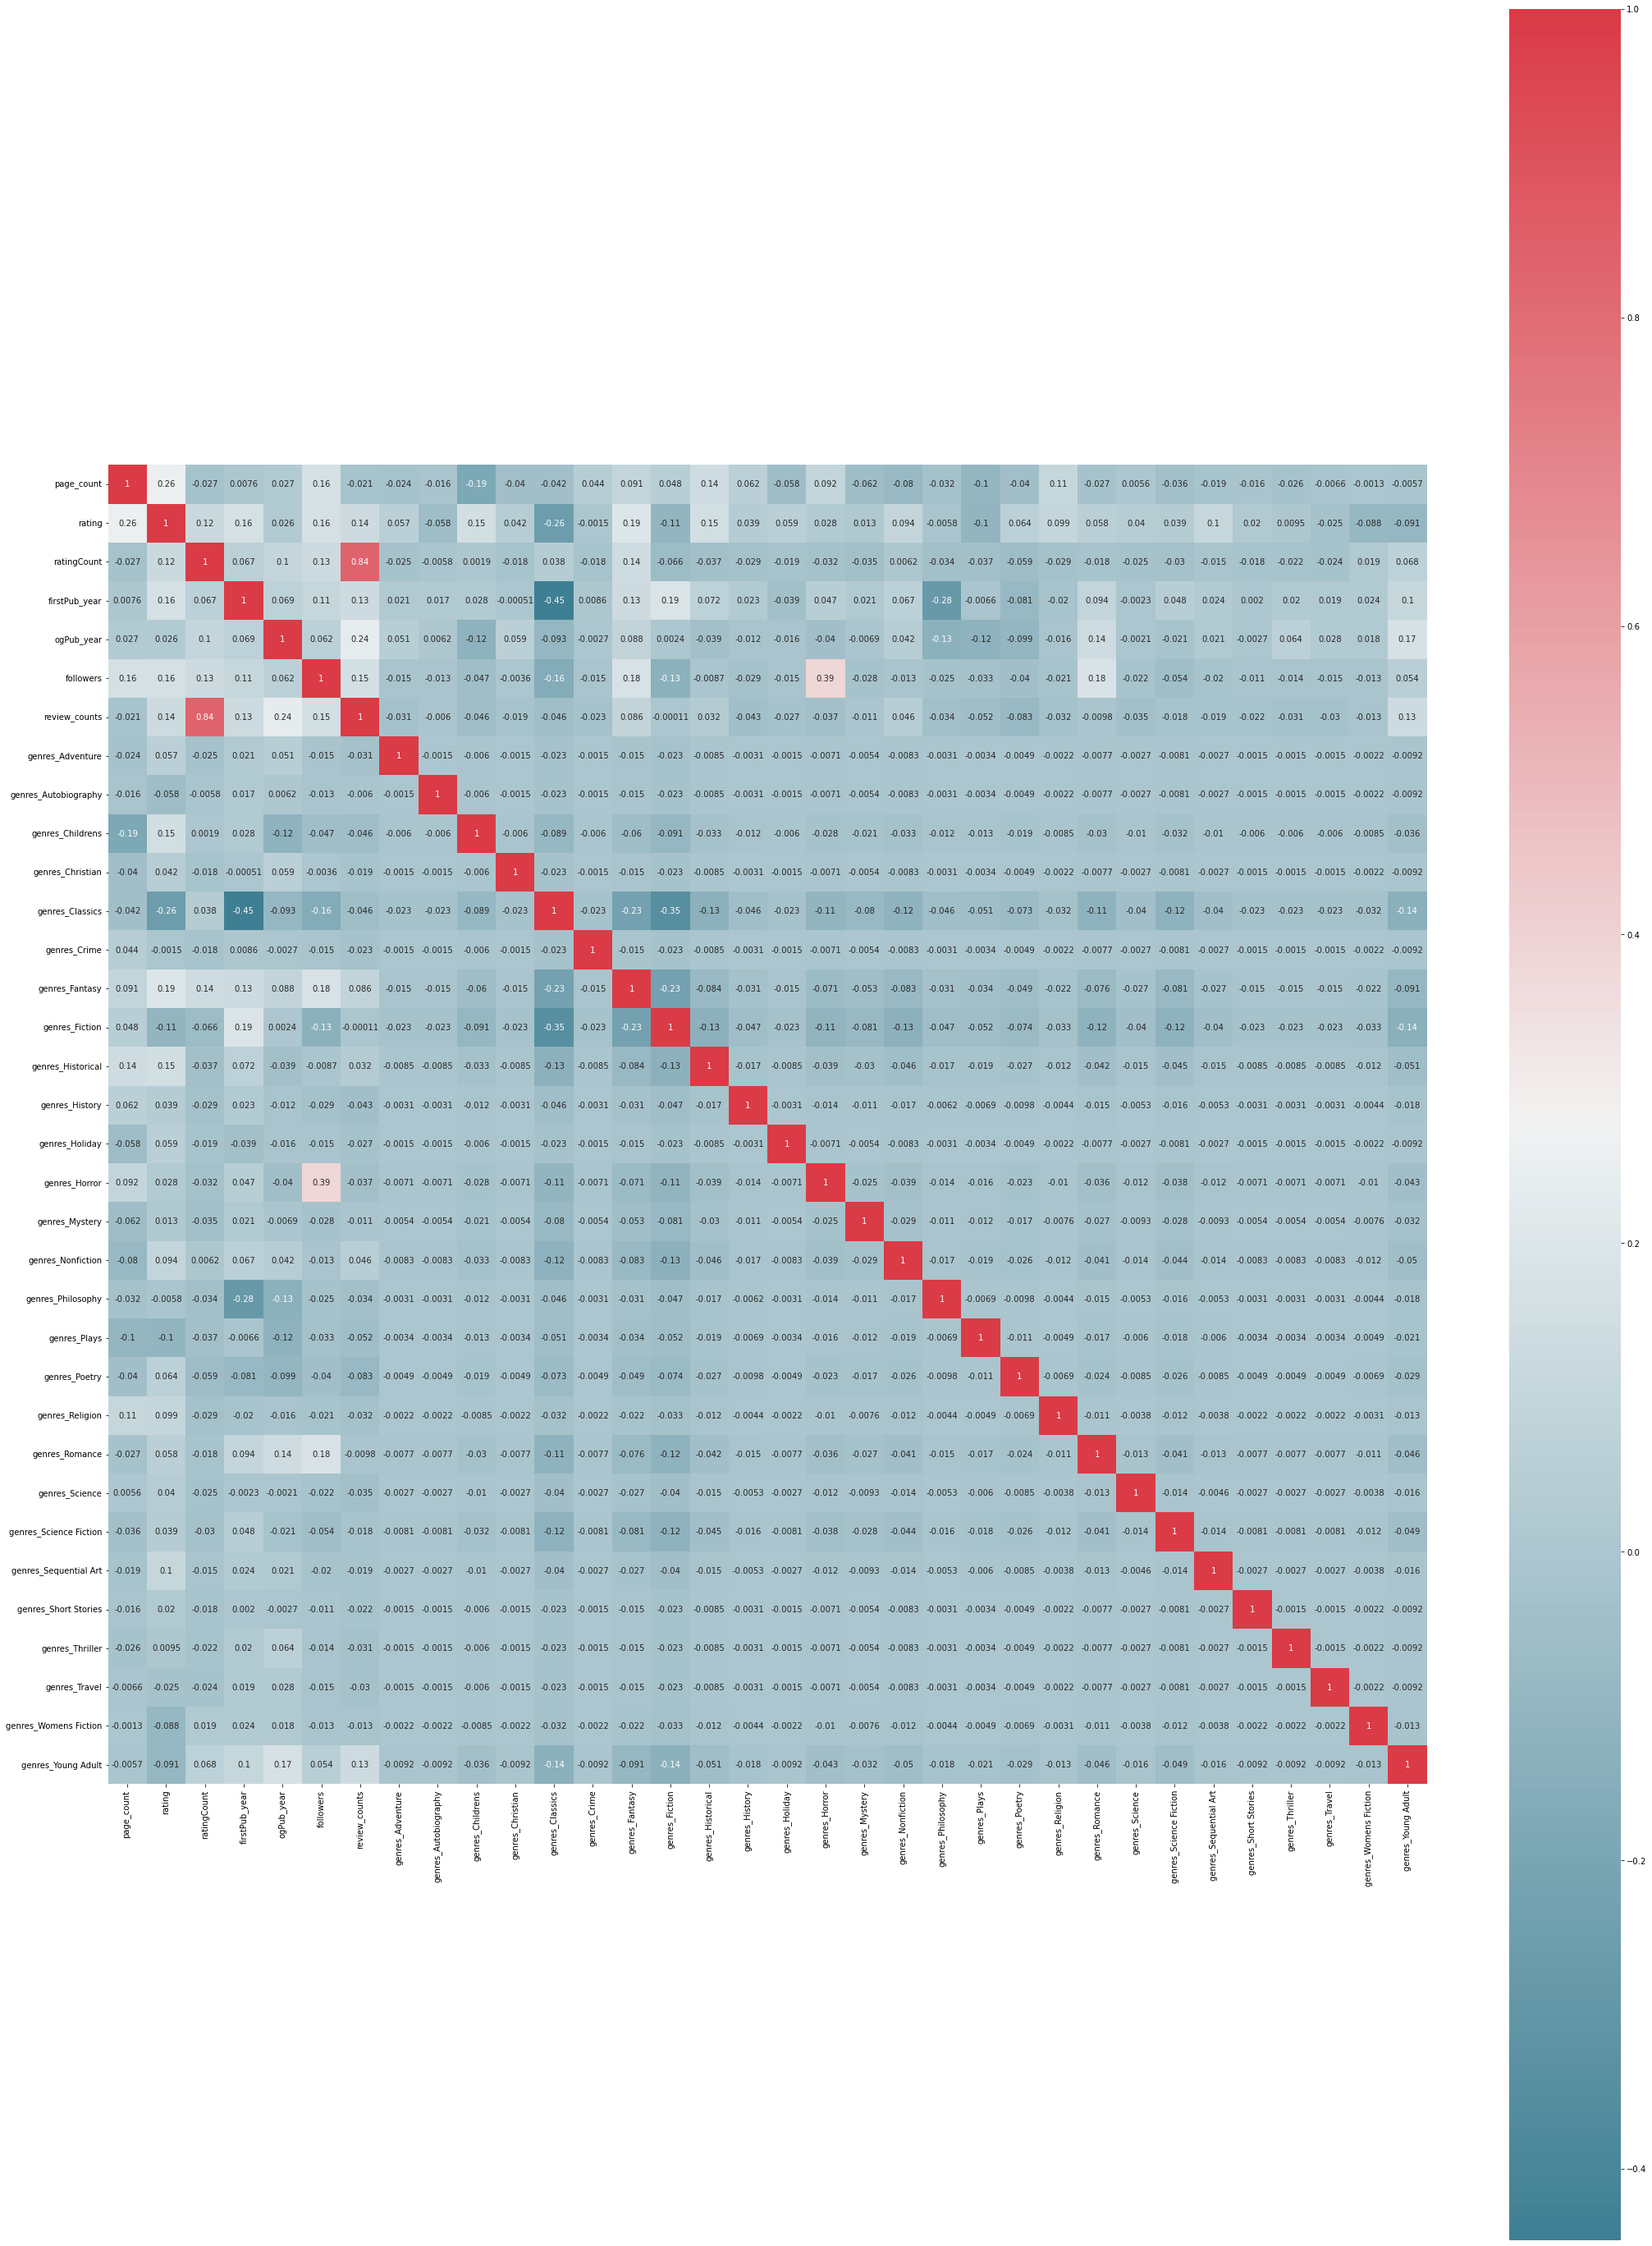

In [102]:
fig = plt.gcf()
fig.set_size_inches(36, 50)
corr = BooksClean_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot = True);

## Modelling along with categorical data:

In [111]:
X_num_cat = BooksClean_df[['page_count','ratingCount','firstPub_year','followers',
       'review_counts','genres_Adventure',
       'genres_Autobiography', 'genres_Childrens', 'genres_Christian',
       'genres_Classics', 'genres_Crime', 'genres_Fantasy', 'genres_Fiction',
       'genres_Historical', 'genres_History', 'genres_Holiday',
       'genres_Horror', 'genres_Mystery', 'genres_Nonfiction',
       'genres_Philosophy', 'genres_Plays', 'genres_Poetry', 'genres_Religion',
       'genres_Romance', 'genres_Science', 'genres_Science Fiction',
       'genres_Sequential Art', 'genres_Short Stories', 'genres_Thriller',
       'genres_Travel', 'genres_Womens Fiction', 'genres_Young Adult']]
y_num_cat = BooksClean_df['rating']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_num_cat, y_num_cat, test_size=0.2, random_state=42)

#simple linear regression model
lr = LinearRegression()
model2_fit = lr.fit(X_train,y_train)

#getting predictions
y_pred = model2_fit.predict(X_test)

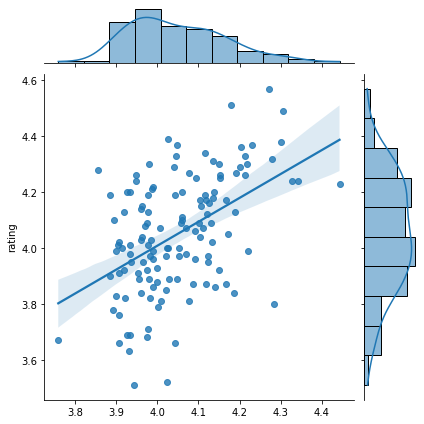

In [113]:
#ploting the actual vs predicted values 
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

In [114]:
print(f'Linear Regression R^2 score on train set: {model2_fit.score(X_train, y_train):.4f}')
print(f'Linear Regression R^2 score on test set: {model2_fit.score(X_test, y_test):.4f}')
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

Linear Regression R^2 score on train set: 0.3198
Linear Regression R^2 score on test set: 0.2265
Mean Absolute Error: 0.1458398496853735
Mean Squared Error: 0.033559682256461866
Root Mean Square Error (RMSE): 0.18319301912589864


In [115]:
pred_2 = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()})
pred_2.head(10)

,Actual,Predicted
0,4.10,3.895347
1,3.87,4.166983
2,3.93,3.999347
3,4.26,4.212266
4,4.07,4.068937
5,3.63,3.930284
6,4.07,4.006618
7,4.26,3.949403
8,4.20,4.060809
9,3.96,4.091190


In [116]:
# AVriance Inflation Factor:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_num_cat.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_num_cat.values, i)
                          for i in range(len(X_num_cat.columns))]
  
print(vif_data)


                   Feature        VIF
0               page_count   1.164918
1              ratingCount   3.680489
2            firstPub_year   1.474557
3                followers   1.399775
4            review_counts   3.770340
5         genres_Adventure   1.589208
6     genres_Autobiography   1.580949
7         genres_Childrens   9.388133
8         genres_Christian   1.546327
9          genres_Classics  83.398370
10            genres_Crime   1.581382
11          genres_Fantasy  50.774494
12          genres_Fiction  98.715828
13       genres_Historical  17.856997
14          genres_History   3.331138
15          genres_Holiday   1.479506
16           genres_Horror  13.297246
17          genres_Mystery   7.711875
18       genres_Nonfiction  16.979493
19       genres_Philosophy   2.308931
20            genres_Plays   3.710907
21           genres_Poetry   6.078573
22         genres_Religion   2.102681
23          genres_Romance  15.099629
24          genres_Science   2.657112
25  genres_S

In [117]:
#Dropping all the features with high VIF:
X_num_cat2 = BooksClean_df[['page_count','ratingCount','firstPub_year','followers',
       'review_counts','genres_Adventure',
       'genres_Autobiography', 'genres_Childrens', 'genres_Christian',
       'genres_Crime', 'genres_History', 'genres_Holiday',
       'genres_Mystery','genres_Philosophy', 'genres_Plays', 'genres_Poetry', 'genres_Religion',
       'genres_Science','genres_Sequential Art', 'genres_Short Stories', 'genres_Thriller',
       'genres_Travel', 'genres_Womens Fiction']]
y_num_cat2 = BooksClean_df['rating']


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_num_cat2, y_num_cat2, test_size=0.2, random_state=42)

#simple linear regression model
lr = LinearRegression()
model3_fit = lr.fit(X_train,y_train)

#getting predictions
y_pred = model3_fit.predict(X_test)

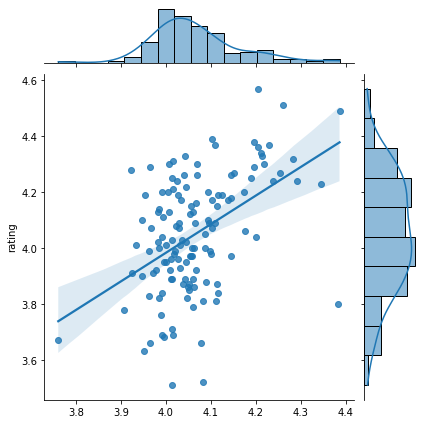

In [119]:
#ploting the actual vs predicted values 
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

In [120]:
print(f'Linear Regression R^2 score on train set: {model3_fit.score(X_train, y_train):.4f}')
print(f'Linear Regression R^2 score on test set: {model3_fit.score(X_test, y_test):.4f}')
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

Linear Regression R^2 score on train set: 0.2210
Linear Regression R^2 score on test set: 0.2180
Mean Absolute Error: 0.1446396365167848
Mean Squared Error: 0.033928198162877836
Root Mean Square Error (RMSE): 0.1841960861768725


In [121]:
y_num = np.log(BooksClean_df['rating'])

#creating a train\validation\test set (80/20/20)
X, X_test, y, y_test = train_test_split(X_num, y_num, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state =41)

In [122]:


#model: simple Linear Model
lm = LinearRegression()
lm.fit(X_train,y_train)
print("R^2 of Train Set:", round(lm.score(X_train,y_train),4))
print("R^2 of Validation Set:", round(lm.score(X_val,y_val),4))
print("R^2 of Test Set:", round(lm.score(X_test,y_test),4))



R^2 of Train Set: 0.1623
R^2 of Validation Set: -0.019
R^2 of Test Set: 0.0508


In [2]:
# Adding polynomialfeatures to see if we can improve the scores:
#polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)

print("R^2 of Train Set with Poly:", round(lr_poly.score(X_train_poly,y_train),4))  
print("R^2 of Validation Set with Poly:", round(lr_poly.score(X_val_poly, y_val),4))
print("R^2 of Test Set with Poly:", round(lr_poly.score(poly.transform(X_test), y_test),4))


NameError: name 'PolynomialFeatures' is not defined

In [124]:
# With hot encoded :
X, X_test, y, y_test = train_test_split(X_num_cat, y_num_cat, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43)

lm = LinearRegression()
lm.fit(X_train,y_train)

print("Linear R^2 of train set including all features:" ,lm.score(X_train,y_train))
print("Linear R^2 of validation set including all features:", lm.score(X_val, y_val))


Linear R^2 of train set including all features: 0.3107200609680677
Linear R^2 of validation set including all features: 0.24535755464241893


In [127]:
from sklearn.linear_model import Ridge

model = Ridge()

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [1000, 100, 10000],
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grad_ridge = GridSearchCV(model, parameters, refit=True)
grad_ridge.fit(X_train, y_train)

print('Best Score: ', grad_ridge.best_score_, '\nBest Parameters: ', grad_ridge.best_params_)

Best Score:  0.2101129652535086 
Best Parameters:  {'alpha': 1, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False}


In [132]:
# Ridge Regression Model
pred_ridge = grad_ridge.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_ridge - y_test) ** 2))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, pred_ridge))))
print('Model Score on Test Data: ', grad_ridge.score(X_test, y_test))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, pred_ridge)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,pred_ridge)))




Residual sum of squares:  0.034910844912014155
RMSE: 0.18684444040970058
Model Score on Test Data:  0.19535935408072702
Mean Absolute Error: 0.14957572649863143
Mean Squared Error: 0.034910844912014155
